In [14]:
from scipy.io import loadmat
import numpy as np
import numpy.ma as ma
import utilities_figures as ufig
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
patient_id = 'ID07'
h_string = '31to39h'
h_offset = 31  # hours
h_range = 9
vmax = 40
ax1_ylim = (0, 150)
ax2_ylim = (0.032, 0.043)
ax3_ylim = None
ax4_ylim = (0.001, 0.003)

In [2]:
# ID07 RNN
patient_id = 'ID07'
h_string = '31to39h'
h_offset = 31  # hours
h_range = 9
vmax = 40
ax1_ylim = (0, 150)
ax2_ylim = None
ax3_ylim = None
ax4_ylim = None

In [2]:
patient_id = 'ID08'
h_string = '57to65h'
h_offset = 57  # hours
h_range = 9
vmax = 800
ax1_ylim = None
ax2_ylim = None
ax3_ylim = None
ax4_ylim = (0.001, 0.0025)

In [15]:
patient_id = 'ID11'
h_string = '59to65h'
h_offset = 59  # hours
h_range = 7
vmax = 300
ax1_ylim = None
ax2_ylim = None
ax3_ylim = (0.3, 0.43)
ax4_ylim = (0.0002, 0.0013)

In [2]:
patient_id = 'ID11'
h_string = '129to137h'
h_offset = 129  # hours
h_range = 9
vmax = 300
ax1_ylim = (0, 2000)
ax2_ylim = None
ax3_ylim = (0.29, 0.46)
ax4_ylim = (0, 0.002)

In [56]:
data_mat = loadmat('../data/' + patient_id + '_' + h_string + '.mat')
info = loadmat('../data/' + patient_id + '_info.mat')
fs = float(info['fs'])
data_np = data_mat['EEG']
data_list = [data_np[i, :] for i in range(data_np.shape[0])]

print(data_list[1].shape)

# Parameters
channel_idx = 0
sw_band = (0.5, 4)
nperseg = int(6*60*fs) #int(20*fs)
noverlap = 0 #int(10*fs)
#t_stamps_0 = [(32, 10), (35, 10), (38, 15)]  # ([h], [min])
#t_stamps_0 = [(58, 0), (60, 2), (64, 40)]  # ([h], [min])
#t_stamps_0 = [(60, 5), (62, 10), (64, 55)]  # ([h], [min])
t_stamps_0 = [(129, 45), (133, 36), (136, 30)]  # ([h], [min])
duration = 5  # [min]

t_stamps = []
for i, val in enumerate(t_stamps_0):
    t_stamps.append(val[0] + val[1]/60)

(25804800,)


In [57]:
data = data_list[channel_idx]

# Get spectral density
f, t, Sxx = signal.spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap, scaling='density')

# Extract slow wave band with tukey window
Sxx_band = Sxx[int(sw_band[0] * Sxx.shape[0] / f[-1]):int(sw_band[1] * Sxx.shape[0] / f[-1]), :]
tukey_window_band = np.tile(signal.tukey(Sxx_band.shape[0]), (Sxx_band.shape[1], 1)).T
Sxx_band_tukey = np.multiply(Sxx_band,  tukey_window_band)

# Compute average band power
swa = np.mean(Sxx_band_tukey, axis=0)

#plt.figure(figsize=(10,5))
#plt.pcolormesh(t, f, Sxx, vmax=vmax, cmap='viridis')
#plt.ylim(0, 30)

In [58]:
corrmean = np.load('../data/corrmean_' + patient_id + '_' + h_string + '_all.npy')

#pre = 'allpos'
pre = 'SLP_allpos'


ids = []
for h_ in range(h_range):
    for m in range(10):  # 30
        h = h_ + h_offset
        m = 6 * m  # 2

        zero = ''
        if m < 10:
            zero = '0'

        t_string = str(h) + 'h' + zero + str(m) + 'm'
        if patient_id == 'ID11':
            if h_offset == 59:
                additional = 'a'
            else:
                additional = 'b'
        else:
            additional = ''
        ids.append(pre + '_' + patient_id + additional + '_' + t_string)

mean_abs, mse, mae, corr = ufig.mean_weights(ids, output=True)
t_results = np.linspace(h_offset, h_offset + h_range, len(mean_abs))


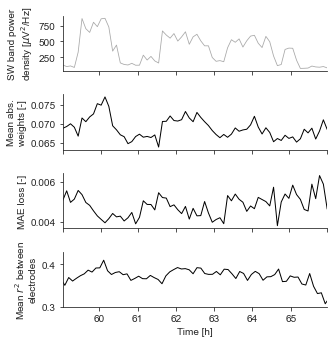

In [61]:
n_subplots = 4
    
fig = plt.figure(figsize=(5, 5))
sns.set_style('ticks')
t_hours = t/60/60 + h_offset
ax = [[], [], [], []]

ax[0] = fig.add_subplot(n_subplots, 1, 1)
plt.plot(t_hours, swa, lw=.8, color='darkgrey', label='unfiltered')
#smooth = signal.savgol_filter(swa, window_length=101, polyorder=3)
#plt.plot(t_hours, smooth, c='black', lw=1, label='filtered')
#plt.legend(loc='upper right', frameon=False)
ax[0].set_xlim(t_hours[0], t_hours[-1])
if ax1_ylim is not None:
    ax[0].set_ylim(ax1_ylim)
ylim = ax[0].get_ylim()
ax[0].set_ylabel('SW band power\ndensity [$\mu$V$^2$/Hz]')
ax[0].set_ylim(ylim)
#ax[0].set_xlabel('Time [h]')

ax[1] = fig.add_subplot(n_subplots, 1, 2)
plt.plot(t_results, mean_abs, c='black', lw=1)
ax[1].set_xlim(t_results[0], t_results[-1])
if ax2_ylim is not None:
    ax[1].set_ylim(ax2_ylim)
ax[1].set_ylabel('Mean abs.\nweights [-]')
#ax[1].set_xlabel('Time [h]')

ax[2] = fig.add_subplot(n_subplots, 1, 3)
plt.plot(t_results, mae, c='black', lw=1)
ax[2].set_xlim(t_results[0], t_results[-1])
#if ax4_ylim is not None:
#    ax[2].set_ylim(ax4_ylim)
ax[2].set_ylabel('MAE loss [-]')

ax[3] = fig.add_subplot(n_subplots, 1, 4)
t_corr = np.linspace(t_hours[0], t_hours[-1], len(corrmean))
upper_ylim = np.max(corrmean)+np.max(corrmean)/10
lower_ylim = np.min(corrmean)-np.min(corrmean)/10
corr_arr = signal.resample(corrmean, len(mean_abs))
plt.plot(t_results, corr_arr, c='black', lw=1)
ax[3].set_xlim(t_hours[0], t_hours[-1])
if ax3_ylim is not None:
    ax[3].set_ylim(ax3_ylim)
else:
    ax[3].set_ylim(lower_ylim, upper_ylim)
ax[3].set_ylabel('Mean $r^2$ between\nelectrodes')
ax[3].set_xlabel('Time [h]')

for i, a in enumerate(ax):
    a.spines['right'].set_visible(False), a.spines['top'].set_visible(False)
    if i < 3:
        plt.setp(a.get_xticklabels(), visible=False)

plt.tight_layout(pad=2)
plt.savefig('figures/fig_Ch3_SleepSegment_ID11a.png', dpi=300)
plt.show()

In [51]:
smooth_rs = signal.resample(smooth, len(mean_abs))
mean_abs_arr = np.asarray(mean_abs)
mae_arr = np.asarray(mae)

In [ ]:
# ID07 Artefact removal
# Artefact Nr. 1
cut_artef_begin = int(mae_arr.shape[0] / 9 * 5.87)
cut_artef_end = int(mae_arr.shape[0] / 9 * 6.34)
dur = cut_artef_end - cut_artef_begin

smooth_rs[cut_artef_begin:cut_artef_end] = np.nan
mean_abs_arr[cut_artef_begin:cut_artef_end] = np.nan
mae_arr[cut_artef_begin:cut_artef_end] = np.nan

# Artefact Nr. 2
mae_arr[int(270/9/60 * 96):int(270/9/60 * 99)] = 0.0018

# Artefact Nr. 3
from_t = int(270/9/60 * 15)
smooth_rs = smooth_rs[from_t:]
mean_abs_arr = mean_abs_arr[from_t:]
mae_arr = mae_arr[from_t:]
t_results_cut = t_results[from_t:]

In [23]:
# ID08 Artefact removal
mean_abs_arr[118:128] = np.nan
mae_arr[118:128] = np.nan
smooth_rs[118:128] = np.nan
corr_arr[118:128] = np.nan

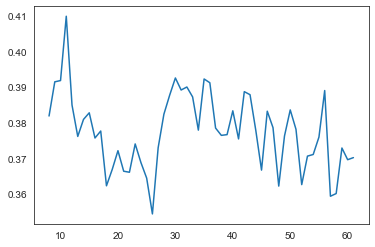

In [53]:
# ID11a Artefact removal
mean_abs_arr[:8] = np.nan
mae_arr[:8] = np.nan
smooth_rs[:8] = np.nan
corr_arr[:8] = np.nan
mean_abs_arr[62:] = np.nan
mae_arr[62:] = np.nan
smooth_rs[62:] = np.nan
corr_arr[62:] = np.nan

plt.plot(corr_arr)

In [12]:
# ID11b Artefact removal
mean_abs_arr[25:250] = np.nan
mae_arr[25:250] = np.nan
smooth_rs[25:250] = np.nan
corr_arr[25:250] = np.nan

SWA: 0.8731482606187023
MAE: -0.3090924957985613
CORR: 0.6337616669158848


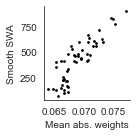

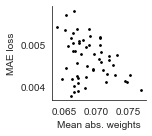

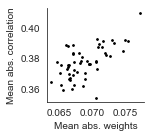

In [54]:
print('SWA: ' + str(ma.corrcoef(ma.masked_invalid(mean_abs_arr), ma.masked_invalid(smooth_rs))[0, 1]))
print('MAE: ' + str(ma.corrcoef(ma.masked_invalid(mean_abs_arr), ma.masked_invalid(mae_arr))[0, 1]))
print('CORR: ' + str(ma.corrcoef(ma.masked_invalid(mean_abs_arr), ma.masked_invalid(corr_arr))[0, 1]))

plt.figure(figsize=(2, 2))
sns.set_style('white')
plt.scatter(mean_abs_arr, smooth_rs, s=3, c='black')
plt.xlabel('Mean abs. weights'), plt.ylabel('Smooth SWA')
ax = plt.gca()
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('r_w_swa.png')

plt.figure(figsize=(2.3, 2))
plt.scatter(mean_abs_arr, mae_arr, s=3, c='black')
plt.xlabel('Mean abs. weights'), plt.ylabel('MAE loss')
ax = plt.gca()
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('r_w_mae.png')

plt.figure(figsize=(2.2, 2))
plt.scatter(mean_abs_arr, corr_arr, s=3, c='black')
plt.xlabel('Mean abs. weights'), plt.ylabel('Mean abs. correlation')
ax = plt.gca()
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('r_w_corr.png')




In [32]:
t_stamps = [67, 256, 442]
for i, val in enumerate(t_stamps):
    val_hour = h_offset+(val/60)
    val_min = (val_hour - np.floor(val_hour)) * 60
    print(str(i) + ' hour: ' + str(np.floor(val_hour)) + ' | min: ' + str(val_min))

0 hour: 32.0 | min: 7.000000000000028
1 hour: 35.0 | min: 15.999999999999943
2 hour: 38.0 | min: 22.00000000000003


In [14]:
corrmat = np.load('../data/corrmat_ID' + ID + '_' + h + '_all.npy')

0.070000000002
0.15
0.22000000000199998


In [32]:
t_stamps

[32.166666666666664, 35.166666666666664, 38.25]

In [63]:
mae_arr.shape

(70,)

In [9]:
ids[0]

'allpos_ID07_31h00m'